# 1-异常检测

异常检测设定的类型
- 监督AD
    * 标签可用于正常和异常数据
    * 类似稀有类挖掘/不平衡分类
- 半监督AD(新奇检测)
    * 只有正常的数据可供训练
    * 该算法仅学习正常数据
- 无监督AD(异常值检测)
    * 没有标签, 训练集 = 正常 + 异常数据
    * 假设: 异常非常罕见

# note:
* [covariance matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)
* [multivariate_normal](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html)
* [seaborn  bivariate kernel density estimate](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"))

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
from sklearn.model_selection import train_test_split

You want to divide data into 3 set. 
1. Training set
2. Cross Validation set
3. Test set.  

You shouldn't be doing prediction using training data or Validation data as it does in the exercise.

In [2]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X = mat.get('X')

In [4]:
mat.get('yval').shape

(307, 1)

divide original validation data into validation and test set

In [5]:
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

Visualize training data

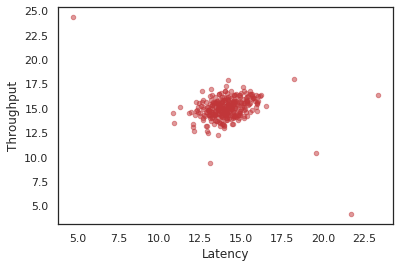

In [6]:
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})
plt.show()

## 协方差矩阵对多元高斯模型的影响

In [7]:
from mpl_toolkits.mplot3d import Axes3D
def plt_multi_gauss(u, sigma):
    def multi_gauss(x1, x2):
        xx = np.stack((x1.ravel(), x2.ravel()), axis=1)
        z = []
        for x in xx:
            z.append(1/(2*np.pi*np.linalg.det(sigma)**0.5) * np.exp(-0.5 * (x - u).T @ np.linalg.inv(sigma) @ (x-u) ))
        z = np.array(z).reshape(x1.shape)
        return z
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    xx, yy = np.meshgrid(x, y)
    z = multi_gauss(xx, yy)
    fig = plt.figure()
#     ax = fig.gca(projection='3d')
#     ax.plot_surface(xx, yy, z, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
    plt.contourf(xx, yy, z, 10, alpha=.75, cmap=plt.cm.hot)
    c = plt.contour(xx, yy, z, colors='black')
    plt.clabel(c, inline=True, fontsize=10)
    plt.axis('scaled')
    plt.show()

In [8]:
u = np.array([0, 0])
sigma = np.array([[1, 0], [0, 1]])

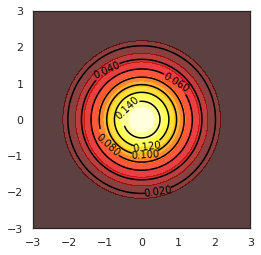

In [9]:
plt_multi_gauss(u, sigma)

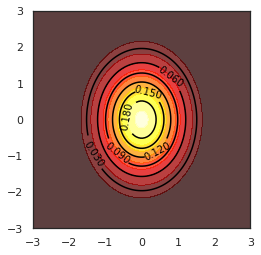

In [10]:
sigma = np.array([[0.6, 0], [0, 1]])
plt_multi_gauss(u, sigma)

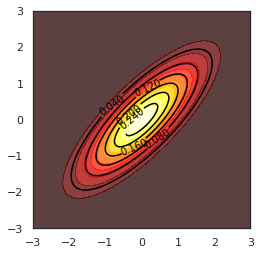

In [11]:
sigma = np.array([[1, 0.8], [0.8, 1]])
plt_multi_gauss(u, sigma)

# estimate multivariate Gaussian parameters $\mu$ and $\sigma^2$
> according to data, X1, and X2 is not independent

In [12]:
mu = X.mean(axis=0)
print(mu, '\n')

cov = np.cov(X.T)  # 协方差矩阵
print(cov)

[14.11222578 14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


$\Sigma = \frac{1}{m}\sum_{i=1}^m(x^{(i)}-\mu)(x^{(i)}-\mu)^T=\frac{1}{m}(X-\mu)^T(X-\mu)$

In [13]:
# example of creating 2d grid to calculate probability density
np.dstack(np.mgrid[0:3,0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

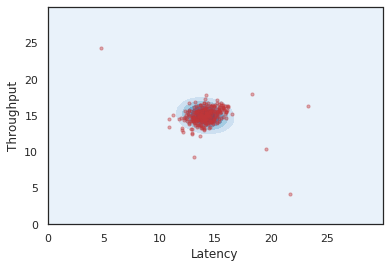

In [14]:
# create multi-var Gaussian model 多元高斯模型
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

# x = np.linspace(-3, 3, 100)
# y = np.linspace(-3, 3, 100)
# xx, yy = np.meshgrid(x, y)

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})
plt.show()

# select threshold $\epsilon$
1. use training set $X$ to model the multivariate Gaussian
2. use cross validation set $(Xval, yval)$ to find the best $\epsilon$ by finding the best `F-score`

<img style="float: left;" src="../img/f1_score.png">

In [15]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


In [16]:
from sklearn.metrics import f1_score, classification_report

In [17]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.304632480092377e-05
Best F-score on validation data: 1.0


# visualize prediction of `Xval` using learned $\epsilon$
1. use CV data to find the best $\epsilon$
2. use all data (training + validation) to create model
3. do the prediction on test data

In [18]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


def predict(X, Xval, e, Xtest, ytest):
    """with optimal epsilon, combine X, Xval and predict Xtest
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    """
    Xdata = np.concatenate((X, Xval), axis=0)

    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # calculate probability of test data
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')

    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred


In [19]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       147
           1       1.00      0.71      0.83         7

    accuracy                           0.99       154
   macro avg       0.99      0.86      0.91       154
weighted avg       0.99      0.99      0.99       154



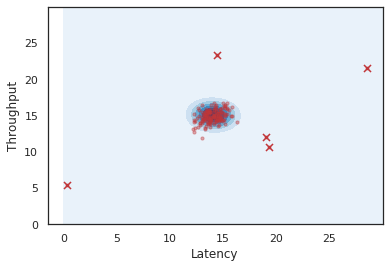

In [20]:
# construct test DataFrame
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot('Latency', 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

# mark the predicted anamoly of CV data. We should have a test set for this...
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)
plt.show()

# high dimension data

In [21]:
mat = sio.loadmat('./data/ex8data2.mat')

In [22]:
X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

In [23]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 2.2773681813670905e-27
Best F-score on validation data: 0.6666666666666666


In [24]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        42
           1       0.00      0.00      0.00         8

    accuracy                           0.84        50
   macro avg       0.42      0.50      0.46        50
weighted avg       0.71      0.84      0.77        50



/home/ulysses/.local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


In [25]:
print('find {} anamolies'.format(y_pred.sum()))

find 0 anamolies


The huge difference between my result, and the official `117` anamolies in the ex8 is due to:
1. my use of **multivariate Gaussian**
2. I split data very differently

In [27]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_features=2, centers=3, n_samples=500, random_state=42)

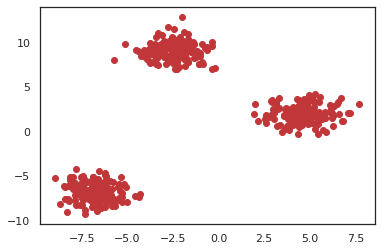

In [28]:
plt.scatter(X[:, 0], X[:, 1])

## 使用密度估计的异常检测

In [31]:
from sklearn.neighbors.kde import KernelDensity
np.set_printoptions(precision=4, threshold=16, suppress=True)


# 使用高斯核密度估计
kde = KernelDensity(kernel='gaussian')
kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [34]:
kde_X = kde.score_samples(X)
kde_X  # 对数似然, 越小样本越罕见

array([-4.0855, -5.3306, -4.9791, ..., -4.4575, -3.8469, -4.394 ])

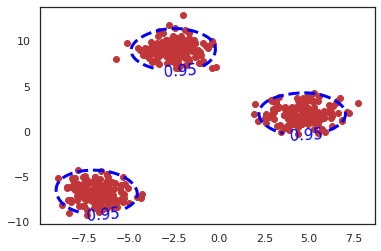

In [36]:
from scipy.stats.mstats import mquantiles
alpha_set = 0.95
tau_kde = mquantiles(kde_X, 1. - alpha_set)  # 0.05分位时的score值

n_samples, n_features = X.shape
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0) - 1.
X_range[:, 1] = np.max(X, axis=0) + 1.

h = 0.1  # step size of the mesh
x_min, x_max = X_range[0]
y_min, y_max = X_range[1]
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

Z_kde = kde.score_samples(grid)
Z_kde = Z_kde.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_kde, levels=tau_kde, colors='blue', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_kde[0]: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## 单类SVM
---
基于密度的估计的问题在于，当数据的维数增加时，它们往往变得低效。 这就是所谓的维度灾难，尤其会影响密度估算算法。 在这种情况下可以使用单类 SVM 算法。

In [48]:
from sklearn.svm import OneClassSVM

nu = 0.05  # 理论上说这应该是离群值的上限, 训练误差的上线
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu)  # Unsupervised Outlier Detection.
ocsvm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
            max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

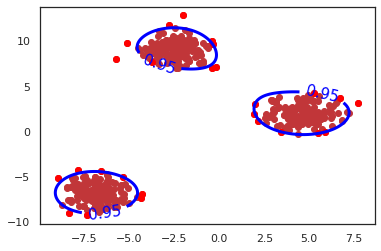

In [49]:
X_outliers = X[ocsvm.predict(X) == -1]

Z_ocsvm = ocsvm.decision_function(grid)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_ocsvm, levels=[0], colors='blue', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={0: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red')
plt.show()

支持向量 - 离群点
---
所谓的单类 SVM 的支持向量形成离群点。

In [46]:
X_SV = X[ocsvm.support_]
n_SV = len(X_SV)
n_outliers = len(X_outliers)

print('{0:.2f} <= {1:.2f} <= {2:.2f}?'.format(1./n_samples*n_outliers, nu, 1./n_samples*n_SV))

0.05 <= 0.05 <= 0.06?


只有支持向量涉及单类 SVM 的决策函数。

- 绘制单类 SVM 决策函数的级别集，就像我们对真实密度所做的那样。
- 突出支持向量。

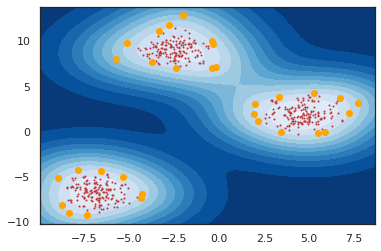

In [47]:
plt.figure()
plt.contourf(xx, yy, Z_ocsvm, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_SV[:, 0], X_SV[:, 1], color='orange')
plt.show()

## 隔离森林
---
隔离森林是一种基于树的异常检测算法。 该算法构建了许多随机树，其基本原理是，如果样本被隔离，在非常少量的随机分割之后，它应该单独存在于叶子中。 隔离森林根据样本最终所在的树的深度建立异常得分。